#  Notebook 4 : Data Augmentation Avancée

**Trash Hero - Tri Intelligent des Déchets par IA**

Dans ce notebook, nous allons :
1. Tester différentes techniques d'augmentation
2. Visualiser l'impact de chaque augmentation
3. Créer un pipeline d'augmentation optimal
4. Ré-entraîner avec les meilleures augmentations

## 4.1 Imports

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4.2 Chargement d'une Image Test

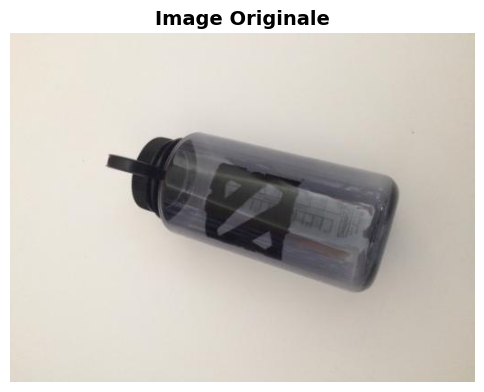

Taille originale: (512, 384)


In [2]:
# Charger une image pour les tests
DATA_ROOT = Path('../data/processed/train')

# Prendre une image au hasard
sample_class = 'plastic'  # Change selon tes classes
images = list((DATA_ROOT / sample_class).glob('*.jpg'))
sample_image_path = images[0]

original_img = Image.open(sample_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.title('Image Originale', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Taille originale: {original_img.size}")

## 4.3 Techniques d'Augmentation Individuelles

### 4.3.1 Flip Horizontal

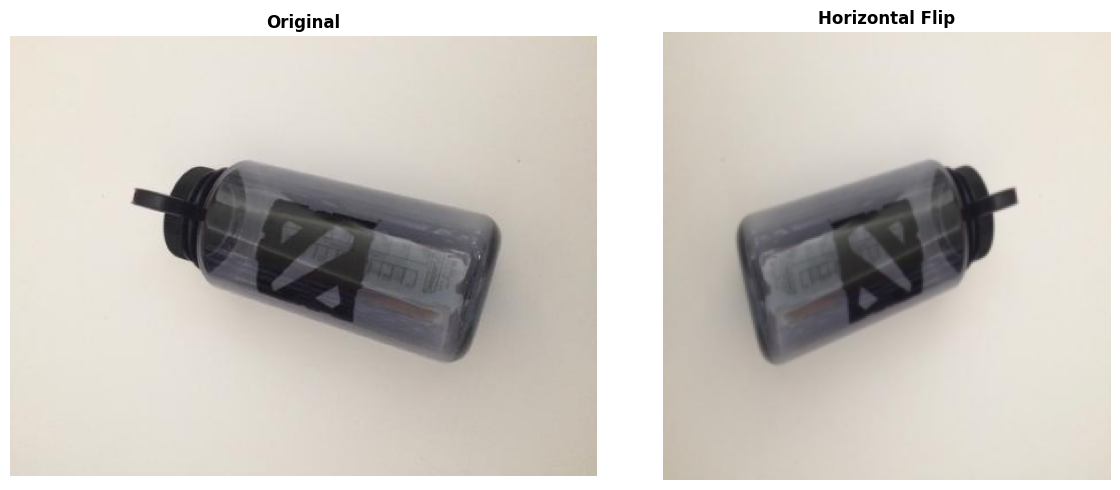

In [3]:
transform_flip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
axes[0].imshow(original_img)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Flipped
flipped = transform_flip(original_img).permute(1, 2, 0)
axes[1].imshow(flipped)
axes[1].set_title('Horizontal Flip', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 4.3.2 Rotation

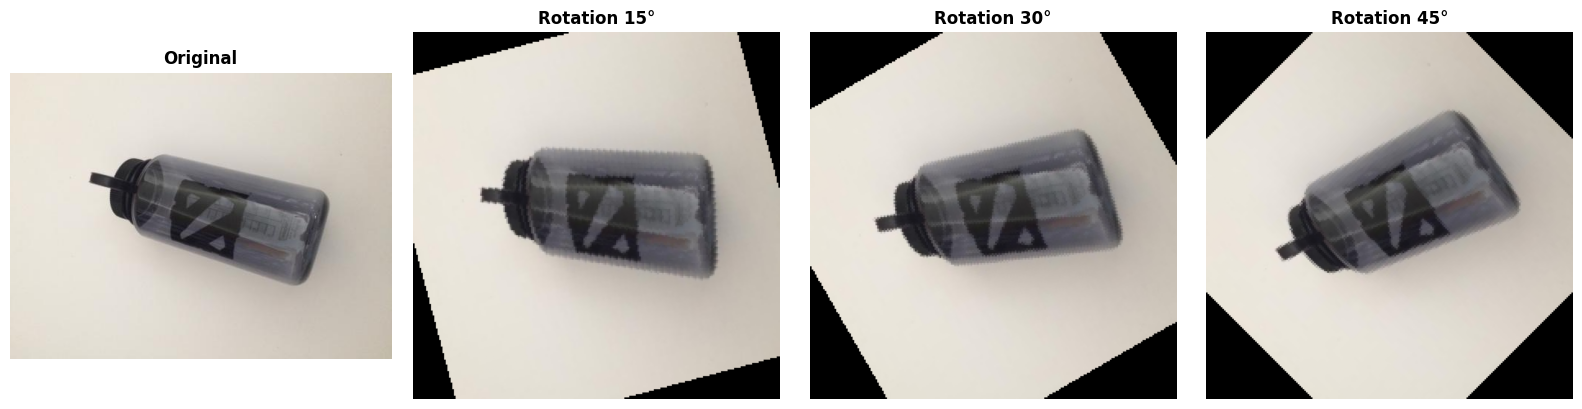

In [4]:
rotation_angles = [15, 30, 45]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
axes[0].imshow(original_img)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Rotations
for idx, angle in enumerate(rotation_angles, 1):
    transform_rot = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(angle, angle)),
        transforms.ToTensor()
    ])
    
    rotated = transform_rot(original_img).permute(1, 2, 0)
    axes[idx].imshow(rotated)
    axes[idx].set_title(f'Rotation {angle}°', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.3.3 Color Jitter

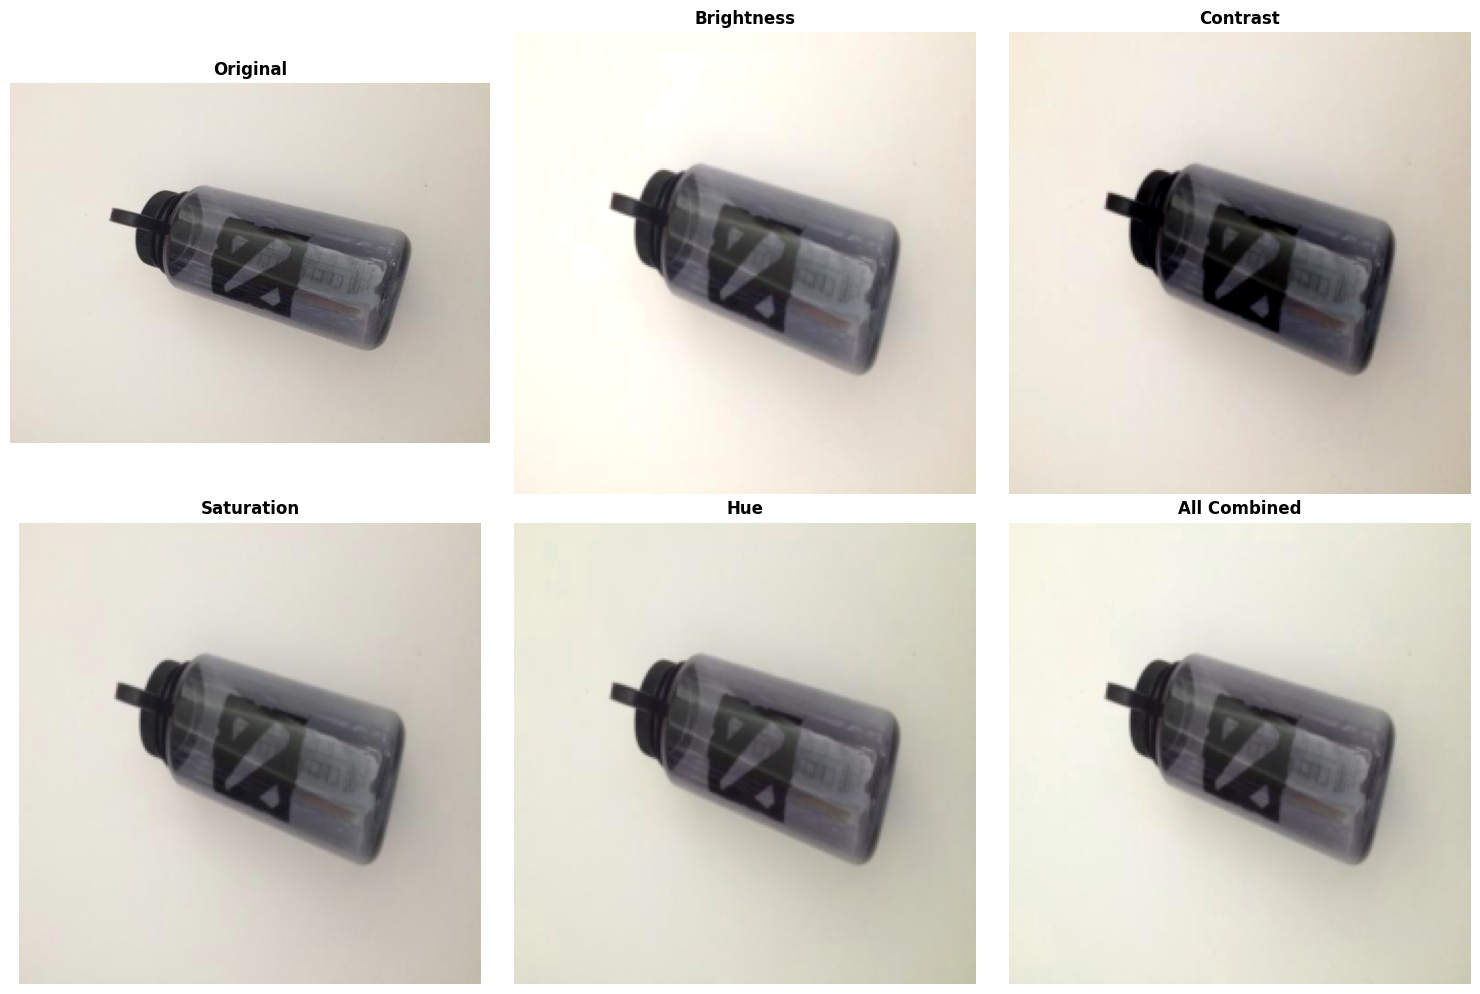

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Original
axes[0].imshow(original_img)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Différents ColorJitter
jitter_configs = [
    {'brightness': 0.3, 'contrast': 0, 'saturation': 0, 'hue': 0},
    {'brightness': 0, 'contrast': 0.3, 'saturation': 0, 'hue': 0},
    {'brightness': 0, 'contrast': 0, 'saturation': 0.3, 'hue': 0},
    {'brightness': 0, 'contrast': 0, 'saturation': 0, 'hue': 0.1},
    {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.1}
]

titles = ['Brightness', 'Contrast', 'Saturation', 'Hue', 'All Combined']

for idx, (config, title) in enumerate(zip(jitter_configs, titles), 1):
    transform_jitter = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(**config),
        transforms.ToTensor()
    ])
    
    jittered = transform_jitter(original_img).permute(1, 2, 0)
    axes[idx].imshow(jittered)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.3.4 Random Crop & Resize

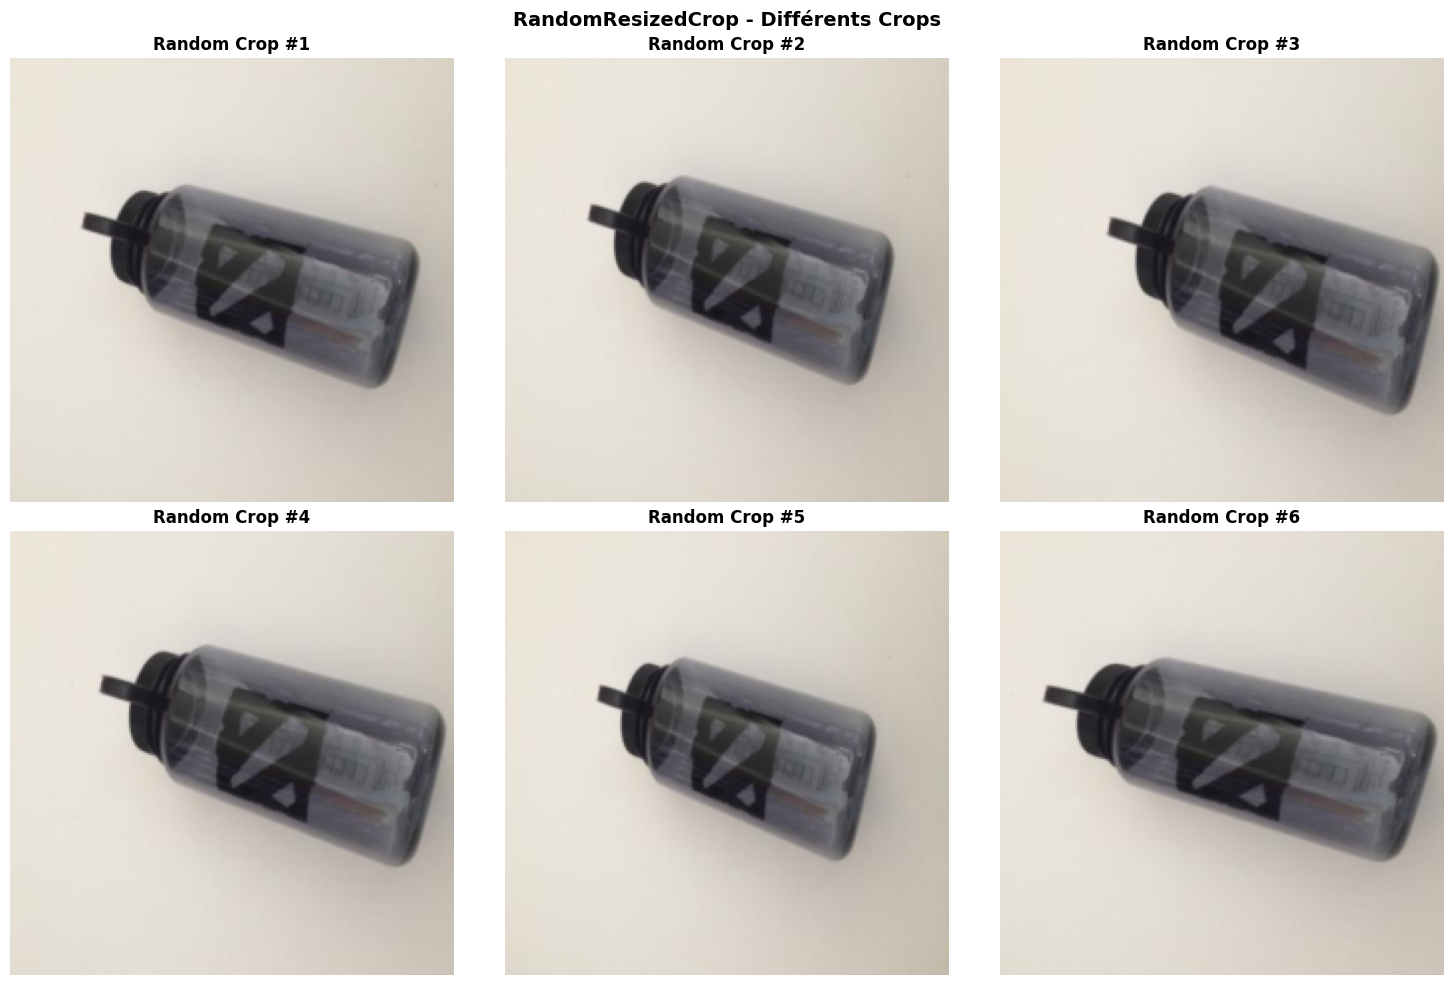

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

transform_crop = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor()
])

for idx in range(6):
    cropped = transform_crop(original_img).permute(1, 2, 0)
    axes[idx].imshow(cropped)
    axes[idx].set_title(f'Random Crop #{idx+1}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('RandomResizedCrop - Différents Crops', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.4 Pipeline d'Augmentation Complet

In [8]:
# Pipeline optimal basé sur les tests
augmentation_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print(" Pipeline d'augmentation optimal créé")
print("\nTransformations incluses:")
print("  1. Resize (224x224)")
print("  2. RandomHorizontalFlip (50%)")
print("  3. RandomRotation (±25°)")
print("  4. RandomResizedCrop (80-100%)")
print("  5. ColorJitter (brightness, contrast, saturation, hue)")
print("  6. Normalisation ImageNet")

 Pipeline d'augmentation optimal créé

Transformations incluses:
  1. Resize (224x224)
  2. RandomHorizontalFlip (50%)
  3. RandomRotation (±25°)
  4. RandomResizedCrop (80-100%)
  5. ColorJitter (brightness, contrast, saturation, hue)
  6. Normalisation ImageNet


## 4.5 Visualisation du Pipeline Complet

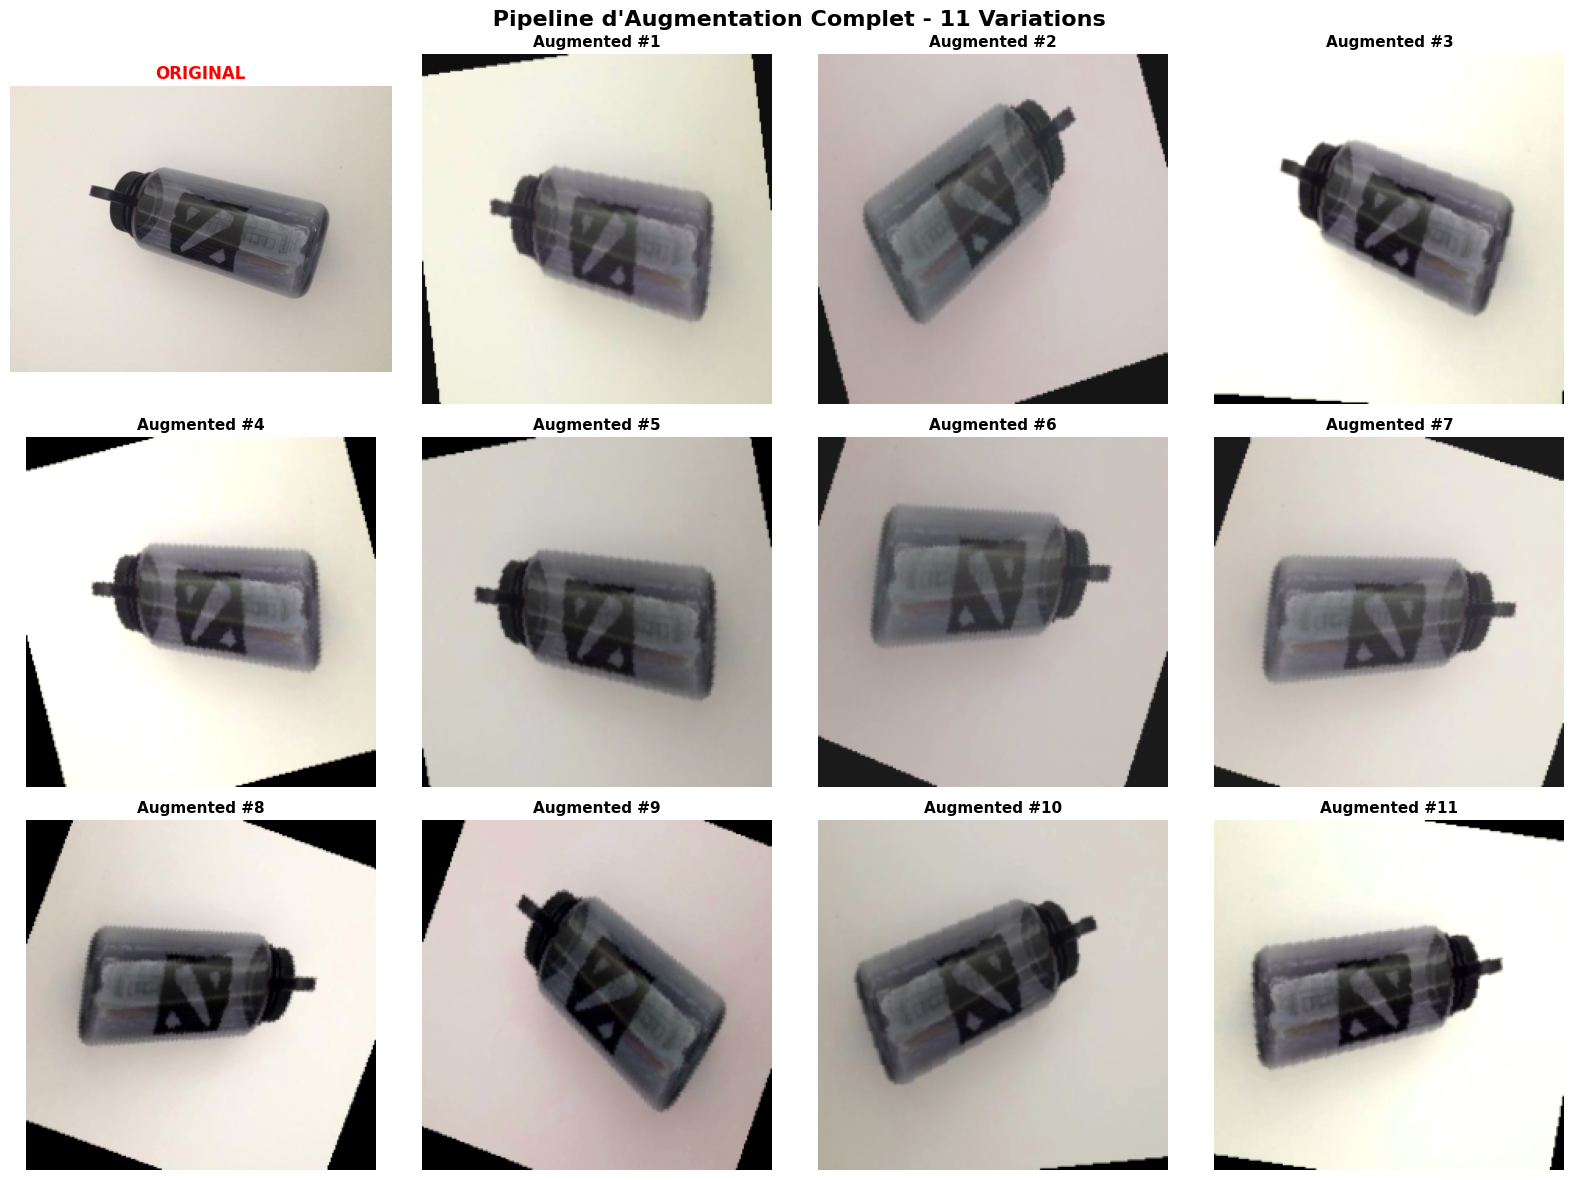

In [9]:
# Fonction pour dénormaliser
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Afficher plusieurs versions augmentées
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

# Original
axes[0].imshow(original_img)
axes[0].set_title('ORIGINAL', fontsize=12, fontweight='bold', color='red')
axes[0].axis('off')

# Versions augmentées
for idx in range(1, 12):
    augmented = augmentation_pipeline(original_img)
    augmented = denormalize(augmented).permute(1, 2, 0).numpy()
    augmented = np.clip(augmented, 0, 1)
    
    axes[idx].imshow(augmented)
    axes[idx].set_title(f'Augmented #{idx}', fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle(' Pipeline d\'Augmentation Complet - 11 Variations', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.6 Comparaison : Avec vs Sans Augmentation

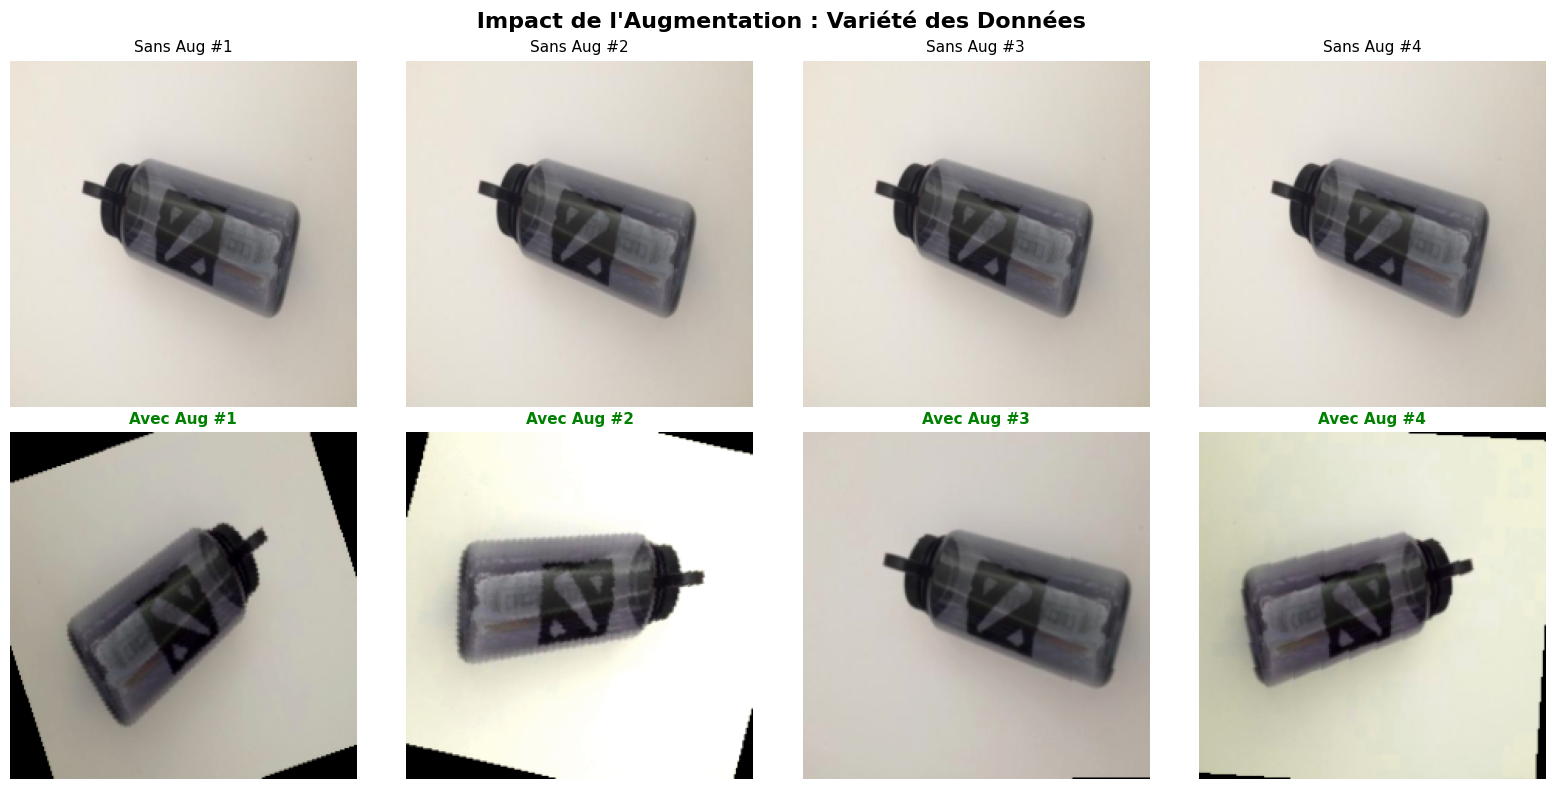


 Observation:
  - Sans augmentation: Toutes les images sont identiques
  - Avec augmentation: Chaque image est unique
  L'augmentation multiplie artificiellement la taille du dataset!


In [10]:
# Sans augmentation
no_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Sans augmentation (toutes identiques)
for idx in range(4):
    img = denormalize(no_aug(original_img)).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'Sans Aug #{idx+1}', fontsize=11)
    axes[0, idx].axis('off')

# Avec augmentation (toutes différentes)
for idx in range(4):
    img = denormalize(augmentation_pipeline(original_img)).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'Avec Aug #{idx+1}', fontsize=11, fontweight='bold', color='green')
    axes[1, idx].axis('off')

plt.suptitle(' Impact de l\'Augmentation : Variété des Données', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n Observation:")
print("  - Sans augmentation: Toutes les images sont identiques")
print("  - Avec augmentation: Chaque image est unique")
print("  L'augmentation multiplie artificiellement la taille du dataset!")

## 4.7 Statistiques d'Augmentation

In [11]:
# Calculer les variations
n_variations = 50
variations = []

for _ in range(n_variations):
    aug_img = augmentation_pipeline(original_img)
    variations.append(aug_img.flatten())

variations = torch.stack(variations)

# Statistiques
mean_variation = variations.std(dim=0).mean().item()

print(f"\n Statistiques sur {n_variations} augmentations:")
print(f"  - Variation moyenne (std): {mean_variation:.4f}")
print(f"  - Augmentation multiplie le dataset par: ~{n_variations}x")
print(f"\n Plus de variété = Meilleure généralisation!")


 Statistiques sur 50 augmentations:
  - Variation moyenne (std): 0.7988
  - Augmentation multiplie le dataset par: ~50x

 Plus de variété = Meilleure généralisation!


## 4.8 Test sur Plusieurs Classes

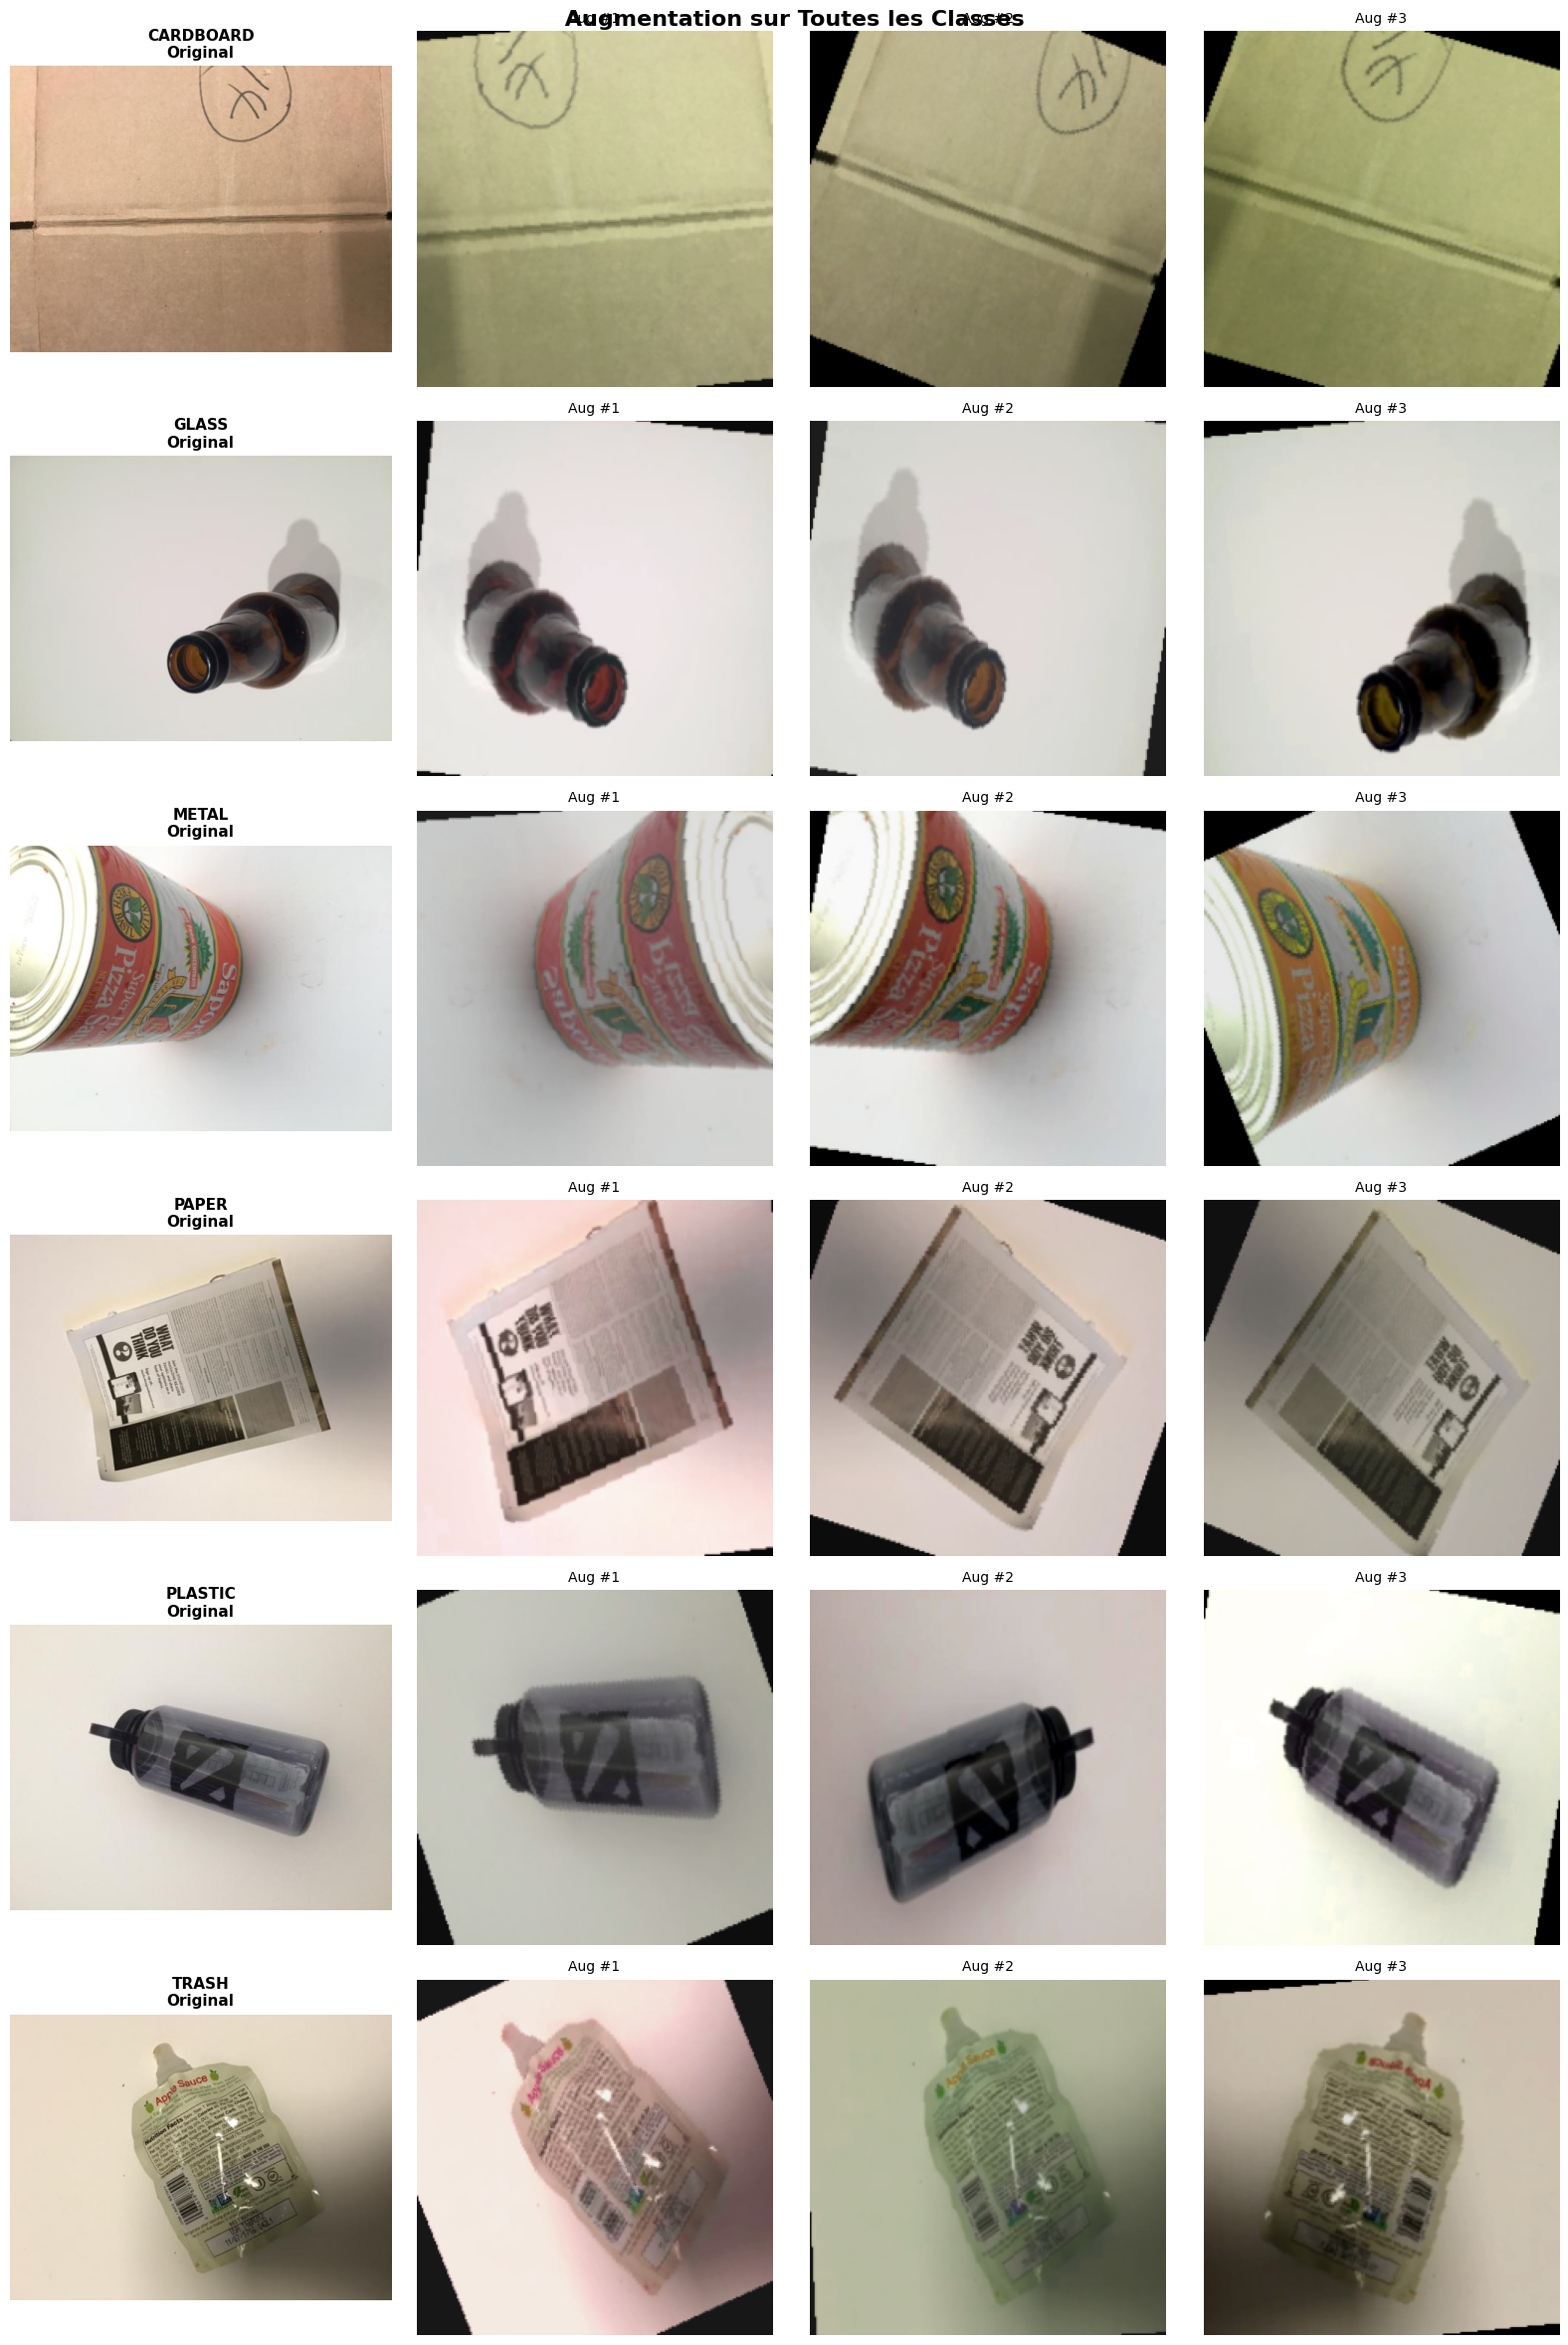

In [12]:
# Tester sur toutes les classes
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

fig, axes = plt.subplots(len(classes), 4, figsize=(16, 4*len(classes)))

for row, cls in enumerate(classes):
    class_images = list((DATA_ROOT / cls).glob('*.jpg'))
    if class_images:
        sample = Image.open(class_images[0])
        
        # Original
        axes[row, 0].imshow(sample)
        axes[row, 0].set_title(f'{cls.upper()}\nOriginal', 
                              fontsize=11, fontweight='bold')
        axes[row, 0].axis('off')
        
        # Augmentées
        for col in range(1, 4):
            aug = denormalize(augmentation_pipeline(sample)).permute(1, 2, 0).numpy()
            aug = np.clip(aug, 0, 1)
            axes[row, col].imshow(aug)
            axes[row, col].set_title(f'Aug #{col}', fontsize=10)
            axes[row, col].axis('off')

plt.suptitle(' Augmentation sur Toutes les Classes', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

##  Résumé

Dans ce notebook, nous avons :

1. Testé différentes techniques d'augmentation individuellement
2. Créé un pipeline optimal combinant plusieurs augmentations
3. Visualisé l'impact de chaque transformation
4. Démontré comment l'augmentation multiplie le dataset

### Pipeline Optimal Retenu:

```python
transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
```

### Prochaine étape

**Notebook 5** : Optimisation du modèle (quantization, pruning)